### Fitting the an Exponential Pulse to find out the pulse duration
The exponential pulse is described as 

$$ \psi(t)=\frac{t}{t_p^2}e^{-t/t_p},$$ 
(Jozef Gembarovic, "Flash Method Data Reduction Using ODRPACK")

1. Generate a simulated, under-sampled pulse with some random noise.
2. Fit the pulse with the model and find out the original pulse duration.

#### Simulated pulse

The pulse mapping signal baseline level ($b$) and the maximum rise value ($s_m$) are unknown parameters, which have to be also evaluated (along with $t_0$ and $t_p$), if we want to reconstruct a real signal coming from our instruments.

Therefore the model function $\phi$ for a real experimental pulse mapping signal is:

$$ \phi(t, b, s_m, t_0, t_p) = b+s_m(t-t_0)e^{(t-t_0)/t_p}$$. 

Note that the term $1/t_p^2$, from the normalized model function $\psi$, is now incorporated into the signal maximum rise $s_m$.

Theoretical pulse maximum: 0.0002  ; detected:  0.000227272727273


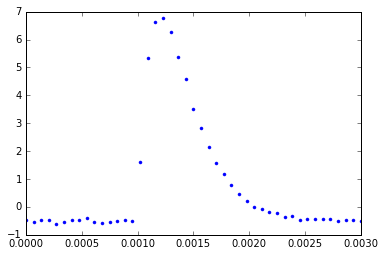

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
noise = 1e-5 # relative to max

def exponential_pulse(params, t):
    """Build an exponential pulse signal from time array `t`"""
    zero_time, pulse_maximum, baseline, Smax = params 
    t1 = t-zero_time
    signal = t1*np.exp(-t1/pulse_maximum)
    # Zero anything before zero_time
    signal[t1<=0] = 0.
    return baseline+Smax*signal

pulse_maximum = 0.0002 #(tp)
sampling_rate = 15000.
baseline = -0.5
Smax = 100000.

zero_time = pulse_maximum*5
signal_duration = zero_time+pulse_maximum*10
num_points = sampling_rate*signal_duration

t = np.linspace(0, signal_duration, num_points)

signal = exponential_pulse([zero_time, pulse_maximum, baseline, Smax], t)
noise = np.random.normal(0, noise/pulse_maximum, len(signal))
signal += noise

undersampled_max = t[np.where(signal==max(signal))[0][0]]-zero_time
print ('Theoretical pulse maximum:',pulse_maximum,' ; detected: ',undersampled_max)
pyplot.plot(t, signal,'b.')
pyplot.show()

#### Fitting the simulated pulse

Beta: [  9.98497603e-04   2.00866438e-04  -5.08673206e-01   9.95539837e+04]
Beta Std Error: [  6.19295536e-07   8.07433032e-07   8.48748065e-03   6.11439152e+02]
Beta Covariance: [[  4.88250319e-09  -3.91562735e-09   1.79289865e-05   2.59932898e+00]
 [ -3.91562735e-09   8.29964777e-09  -3.66777613e-05  -5.47749331e+00]
 [  1.79289865e-05  -3.66777613e-05   9.17073685e-01   9.10702141e+03]
 [  2.59932898e+00  -5.47749331e+00   9.10702141e+03   4.75941008e+09]]
Residual Variance: 7.855129749005776e-05
Inverse Condition #: 0.004155722635557986
Reason(s) for Halting:
  Sum of squares convergence


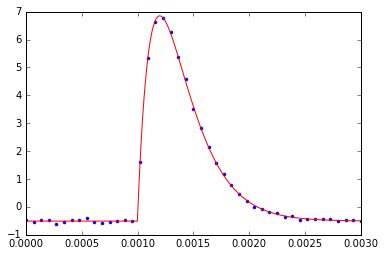

Fitted pulse maximum: 0.000200866437993 Theoretical: 0.0002
Fitted zero time: 0.000998497603221 Theoretical: 0.001


In [2]:
import scipy.odr.odrpack as odrpack
import os
filename='pulse_odr.log'
if os.path.exists(filename):
    os.remove(filename)
    
model = odrpack.Model(exponential_pulse)
data = odrpack.RealData(t, signal, sx=0.1/sampling_rate, sy=0.001/pulse_maximum)
odrobj = odrpack.ODR(data, model, beta0=[0., 0.0005, -1., 4000], job=3, 
                    iprint=6616, ifixb=[1, 1, 1, 1], rptfile=filename)             
                                                    
output = odrobj.run() 
output.pprint() 

th_time=np.linspace(0, signal_duration, num_points*100)
fitted_zero_time, fitted_max, fitted_baseline,fitted_Smax = output.beta
pyplot.plot(t, signal,"b.")
pyplot.plot(th_time, exponential_pulse([fitted_zero_time, fitted_max,fitted_baseline,fitted_Smax], th_time),"r")
pyplot.show()
print ('Fitted pulse maximum:', fitted_max, 'Theoretical:', pulse_maximum)
print ('Fitted zero time:', fitted_zero_time, 'Theoretical:', zero_time)
